In [1]:
import numpy as np 
import pandas as pd 

import os
import torch
import torchvision
from PIL import Image
import os.path
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
traincsvPath = "/content/drive/MyDrive/Thermal Imaging/Readings_training.csv"
testcsvPath = "/content/drive/MyDrive/Thermal Imaging/Readings_testing.csv"
valcsvPath = "/content/drive/MyDrive/Thermal Imaging/Readings_validation.csv"
dataPath = "/content/drive/MyDrive/Thermal Imaging/DATASET/Filtered/"
bestModelPath = "/content/drive/MyDrive/Thermal Imaging/bestModel.pth"

In [5]:
traindf = pd.read_csv(traincsvPath)
testdf = pd.read_csv(testcsvPath)
valdf = pd.read_csv(valcsvPath)

# Create a list of train, test and val images, SBP and DBP

In [6]:
trainLabels = []
testLabels = []
valLabels = []

trainSBP = []
testSBP = []
valSBP = []

trainDBP = []
testDBP = []
valDBP = []

In [7]:
for index, row in traindf.iterrows():
  if os.path.isfile(dataPath + row['Image'])  is False:
    continue
  trainLabels.append(dataPath + row['Image'])
  trainSBP.append(row['SBP'])
  trainDBP.append(row['DBP'])

for index, row in testdf.iterrows():
  if os.path.isfile(dataPath + row['Image'])  is False:
    continue
  testLabels.append(dataPath + row['Image'])
  testSBP.append(row['SBP'])
  testDBP.append(row['DBP'])

for index, row in valdf.iterrows():
  if os.path.isfile(dataPath + row['Image'])  is False:
    continue
  valLabels.append(dataPath + row['Image'])
  valSBP.append(row['SBP'])
  valDBP.append(row['DBP'])

# Apply Image transformation, extract features and create dataloader class

## Image Transformation and feature extraction model

In [8]:
# Image Transformations as expected by resnet101 as input
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
googleNet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
googleNet

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [10]:
layers = list(googleNet.children())[:-1]
googleNetModel = torch.nn.Sequential(*layers)
googleNetModel.to('cpu')
googleNetModel.eval()
googleNetModel

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (5): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (bra

In [11]:
trainImgs, testImgs, valImgs = [], [], []

# Transform and load image vectors in trainImgs, testImgs, valImgs
for img in trainLabels:
  image = Image.open(os.path.join(dataPath, img))
  image = preprocess(image).unsqueeze(0)
  feature = googleNetModel(image).detach().numpy()
  trainImgs.append(feature)

for img in testLabels:
  image = Image.open(os.path.join(dataPath, img))
  image = preprocess(image).unsqueeze(0)
  feature = googleNetModel(image).detach().numpy()
  testImgs.append(feature)

for img in valLabels:
  image = Image.open(os.path.join(dataPath, img))
  image = preprocess(image).unsqueeze(0)
  feature = googleNetModel(image).detach().numpy()
  valImgs.append(feature)


In [12]:
# Dataset class 
class thermalDataset(Dataset):
  def __init__(self, features, sbp, dbp):
      super().__init__()
      self.features = features
      self.sbp = sbp 
      self.dbp = dbp

  def __len__(self):
    return len(self.features)

  def __getitem__(self, indx):
    self.sbp[indx] = np.float32(self.sbp[indx] / 180.00)
    self.dbp[indx] = np.float32(self.dbp[indx] / 180.00)
    return {'feature': self.features[indx], 'sbp': self.sbp[indx], 'dbp': self.dbp[indx]}

In [13]:
train_dataset = thermalDataset(trainImgs, trainSBP, trainDBP)
test_dataset = thermalDataset(testImgs, testSBP, testDBP)
val_dataset = thermalDataset(valImgs, testSBP, testDBP)

train_data_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True, num_workers = 1)
test_data_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = True, num_workers = 1)
val_data_loader = DataLoader(dataset = val_dataset, batch_size = 16, shuffle = True, num_workers = 1)

# Model Implementation (Alexnet Feature Layers + Dense Layers)

In [14]:
# Removed classification layers, used pretrained alexnet for feature extraction, added own fcc layers.
class modifiedpreTrainedgoogleNet(torch.nn.Module):
  def __init__(self):
    super(modifiedpreTrainedgoogleNet, self).__init__()
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(1024, 1024, bias=True)

    self.fcsbp1 = torch.nn.Linear(1024, 4096, bias=True) #FOR SBP
    self.fcsbp2 = torch.nn.Linear(4096, 2048, bias=True)
    self.fcsbpout = torch.nn.Linear(2048, 1, bias=True) # SBP output

    self.fcdbp1 = torch.nn.Linear(1024, 4096, bias=True) #For DBP
    self.fcdbp2 = torch.nn.Linear(4096, 2048, bias=True) 
    self.fcdbpout = torch.nn.Linear(2048, 1, bias=True) #DBP output

  def forward(self, features):
    features = self.flatten(features)
    features = F.relu(self.fc1(features)) #First FCC Layer

    sbp = F.relu(self.fcsbp1(features))     #SBP output
    sbp = F.relu(self.fcsbp2(sbp))
    sbp = F.relu(self.fcsbpout(sbp))

    dbp = F.relu(self.fcdbp1(features))     #DBP output
    dbp = F.relu(self.fcdbp2(dbp))
    dbp = F.relu(self.fcdbpout(dbp))

    return {'sbp': sbp, 'dbp': dbp}

    

In [15]:
def plotLosses(trainLoss, validationLoss, trainSBP, trainDBP, valSBP, valDBP):
  plt.figure(figsize=(10,5))
  plt.plot(trainLoss)
  plt.plot(validationLoss)
  plt.plot(trainSBP)
  plt.plot(trainDBP)
  plt.plot(valSBP)
  plt.plot(valDBP)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Epoch vs Loss")
  plt.legend(['Training Loss', 'Validation Loss', 'Train SBP Loss', 'Train DBP Loss', 'Val SBP loss', 'Val DBP Loss'])
  plt.grid()
  plt.show()

# Training the model

Epoch:  0   TrainLoss:  2.870648354291916 TrainSBPLoss:  1.987457200884819 TrainDBPLoss:  0.8831910789012909
Epoch:  0   ValLoss:  2.870648354291916 ValSBPLoss:  1.987457200884819 ValDBPLoss:  0.8831910789012909
Epoch:  1   TrainLoss:  0.32372542517259717 TrainSBPLoss:  0.2008963207481429 TrainDBPLoss:  0.1228291005390929
Epoch:  1   ValLoss:  0.32372542517259717 ValSBPLoss:  0.2008963207481429 ValDBPLoss:  0.1228291005390929
Epoch:  2   TrainLoss:  0.3085934016853571 TrainSBPLoss:  0.23243715148419142 TrainDBPLoss:  0.07615624601021409
Epoch:  2   ValLoss:  0.3085934016853571 ValSBPLoss:  0.23243715148419142 ValDBPLoss:  0.07615624601021409
Epoch:  3   TrainLoss:  0.1187404952943325 TrainSBPLoss:  0.06803165376186371 TrainDBPLoss:  0.05070884502492845
Epoch:  3   ValLoss:  0.1187404952943325 ValSBPLoss:  0.06803165376186371 ValDBPLoss:  0.05070884502492845
Epoch:  4   TrainLoss:  0.04906730749644339 TrainSBPLoss:  0.039725205628201365 TrainDBPLoss:  0.009342101049696794
Epoch:  4   Va

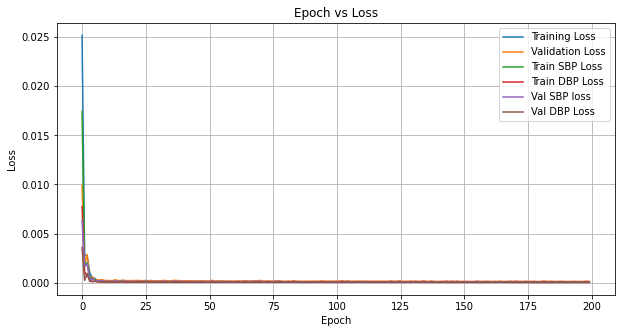

In [16]:
num_epochs = 200
steps_per_epoch = len(trainImgs)
model = modifiedpreTrainedgoogleNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()

trainLoss = []
validationLoss = []
trainSBPLoss = []
trainDBPLoss = []
valSBPLoss = []
valDBPLoss = []

valLossMIN = 10000

for epoch in range(num_epochs):
  trainloss = 0.0
  valLoss = 0.0
  trainsbpLoss = 0.0
  traindbpLoss = 0.0
  valsbpLoss = 0.0
  valdbpLoss = 0.0
  model.train()

  for batch_idx, sample in enumerate(train_data_loader):
    feature, sbp, dbp = sample['feature'].to(device), sample['sbp'].to(device), sample['dbp'].to(device)
    optimizer.zero_grad()
    output = model(feature)
    sbp = sbp.unsqueeze(1)
    dbp = dbp.unsqueeze(1)
    sbpLoss = criterion(output['sbp'], sbp)
    dbpLoss = criterion(output['dbp'], dbp)
    loss = sbpLoss + dbpLoss
    loss.backward()
    optimizer.step()    

    trainloss += loss.item()
    trainsbpLoss += sbpLoss.item()
    traindbpLoss += dbpLoss.item()

  trainLoss.append(trainloss/len(trainImgs))
  trainSBPLoss.append(trainsbpLoss/len(trainImgs))
  trainDBPLoss.append(traindbpLoss/len(trainImgs))

  print("Epoch: ", epoch, "  TrainLoss: ", trainloss, "TrainSBPLoss: ", trainsbpLoss, "TrainDBPLoss: ", traindbpLoss)

  with torch.no_grad():
    model.eval()
    for batch_idx, sample in enumerate(val_data_loader):
      feature, sbp, dbp = sample['feature'].to(device), sample['sbp'].to(device), sample['dbp'].to(device)
      output = model(feature)
      sbp = sbp.unsqueeze(1)
      dbp = dbp.unsqueeze(1)
      sbpLoss = criterion(output['sbp'], sbp)
      dbpLoss = criterion(output['dbp'], dbp)
      loss = sbpLoss + dbpLoss
      
      valLoss += loss.item()
      valsbpLoss += sbpLoss.item()
      valdbpLoss += dbpLoss.item()

  validationLoss.append(valLoss/len(valImgs))
  valSBPLoss.append(valsbpLoss/len(valImgs))
  valDBPLoss.append(valdbpLoss/len(valImgs))  

  print("Epoch: ", epoch, "  ValLoss: ", trainloss, "ValSBPLoss: ", trainsbpLoss, "ValDBPLoss: ", traindbpLoss)

plotLosses(trainLoss, validationLoss, trainSBPLoss, trainDBPLoss, valSBPLoss, valDBPLoss)

# Testing the model

In [17]:
sbps = []
dbps = []
outputsbps = []
outputdbps = []

with torch.no_grad():
  model.eval()
  for batch_idx, sample in enumerate(test_data_loader):
    feature, sbp, dbp = sample['feature'].to(device), sample['sbp'].to(device), sample['dbp'].to(device)
    output = model(feature)
    sbps.append(sbp.unsqueeze(1))
    dbps.append(dbp.unsqueeze(1))
    outputsbps.append(output['sbp'])
    outputdbps.append(output['dbp'])

In [18]:
sbp = sbps[0]
dbp = dbps[0]
outputsbp = outputsbps[0]
outputdbp = outputdbps[0]

for i in range(1,len(sbps)):
  sbp = torch.cat((sbp, sbps[i]))
  dbp = torch.cat((dbp, dbps[i]))
  outputsbp = torch.cat((outputsbp, outputsbps[i]))
  outputdbp = torch.cat((outputdbp, outputdbps[i]))

In [19]:
# Calculates Mean Absolute % error
def MAPELoss(output, target):
  return torch.mean(torch.abs((target - output)*100.0 / target))

def MAE(output, target):
  return torch.mean(torch.abs(target-output)*180.0)

def stdError(output, target):
  return torch.std((target-output)*180.0)

In [20]:
print("MAPE for SBP: ", MAPELoss(outputsbp, sbp), "MAPE for DBP: ", MAPELoss(outputdbp, dbp))
print("MAE for SBP: ", MAE(outputsbp, sbp), "MAE for DBP: ", MAE(outputdbp, dbp))
print("Standard deviation SBP: ", stdError(outputsbp, sbp), "Standard deviation DBP: ", stdError(outputdbp, dbp))

MAPE for SBP:  tensor(3.1469, device='cuda:0') MAPE for DBP:  tensor(4.1969, device='cuda:0')
MAE for SBP:  tensor(3.5932, device='cuda:0') MAE for DBP:  tensor(2.8693, device='cuda:0')
Standard deviation SBP:  tensor(4.4907, device='cuda:0') Standard deviation DBP:  tensor(3.7535, device='cuda:0')


# Visualizations

## Ground value vs Predicted Value

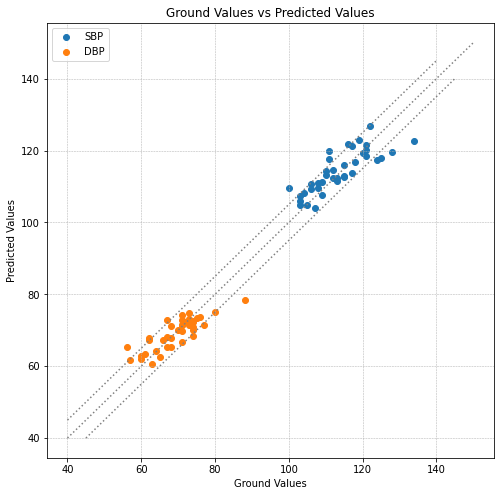

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(sbp.to('cpu')*180.0, outputsbp.to('cpu')*180.0)
plt.scatter(dbp.to('cpu')*180.0, outputdbp.to('cpu')*180.0)
plt.xlabel("Ground Values")
plt.ylabel("Predicted Values")
plt.title("Ground Values vs Predicted Values")
plt.legend(['SBP', 'DBP'])
plt.plot([40, 150], [40, 150], ls='dotted', color='#808080')

# +-  10 mm Hg range
# plt.plot([40, 140], [50, 150], ls='dotted', color='#808080')
# plt.plot([50, 150], [40, 140], ls='dotted', color='#808080')

# +- 5 mm Hg range
plt.plot([40, 140], [45, 145], ls='dotted', color='#808080')
plt.plot([45, 145], [40, 140], ls='dotted', color='#808080')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

## Absolute Error (DBP) vs Absolute Error(SBP)

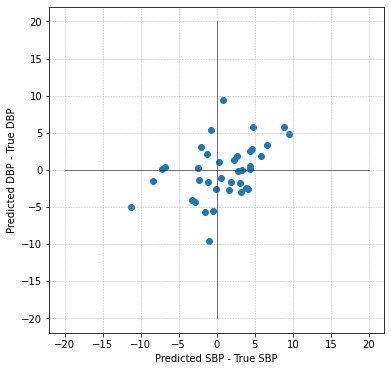

In [22]:
sbpError = outputsbp - sbp
dbpError = outputdbp - dbp

plt.figure(figsize=(6,6))
plt.scatter(sbpError.to('cpu')*180.0, dbpError.to('cpu')*180.0)
plt.xlabel("Predicted SBP - True SBP")
plt.ylabel("Predicted DBP - True DBP")
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot([0, 0], [-20, 20], linewidth = 0.5, color="#000000")
plt.plot([-20, 20], [0, 0], linewidth = 0.5, color="#000000")
plt.xticks([-20, -15, -10, -5, 0, 5, 10, 15, 20])
plt.yticks([-20, -15, -10, -5, 0, 5, 10, 15, 20])
plt.show()